In [258]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd

In [259]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
usa = world[world['ADMIN'] == 'United States of America']

In [260]:
pt = Point(-84.59, 29.88)
gdf_pt = gpd.GeoSeries([pt], crs="EPSG:4326").to_frame(name="geometry")

In [261]:
storm_24 = pd.read_csv('/Users/jimnguyen/IRMII/SCS_API/data/Storm_Reports/filtered/Storm_Reports_2024_latlong.csv')

In [262]:
storm_24 = storm_24.drop(['MONTH_NAME','END_DAY','STATE','CZ_TYPE','CZ_NAME','END_LAT','END_LON'],axis=1)


In [263]:
storm_24 = storm_24.drop(['YEAR'],axis=1)

In [264]:
storm_24 = storm_24.rename(columns={'BEGIN_LAT': 'LAT', 'BEGIN_LON': 'LON','MONTH_NUM':'Month','BEGIN_DAY':'DAY'})
storm_24

,DAY,EVENT_TYPE,LAT,LON,Month
0,8,Hail,30.0414,-96.3191,1
1,8,Hail,29.5000,-96.5700,1
2,8,Hail,33.1400,-91.0660,1
3,8,Hail,32.8500,-90.4100,1
4,8,Hail,31.0400,-89.1800,1
...,...,...,...,...,...
36499,29,Tornado,33.2174,-84.5236,12
36500,29,Tornado,33.2210,-84.5210,12
36501,29,Tornado,33.3379,-84.4562,12
36502,29,Tornado,34.0332,-84.4893,12


In [265]:
storm_24['EVENT_TYPE'].unique()

array(['Hail', 'High Wind', 'Strong Wind', 'Thunderstorm Wind', 'Tornado'],
      dtype=object)

In [266]:
storm_24.loc[storm_24['EVENT_TYPE'].str.contains('Wind',case=False, na=False),'EVENT_TYPE']='Wind'

<Axes: >

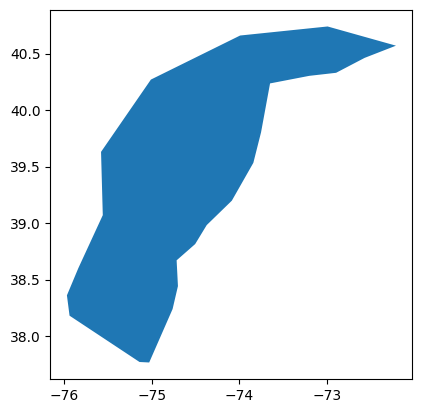

In [267]:
convective_path_24 = "/USERS/jimnguyen/IRMII/SCS_API/convective_outlooks/2024"
#inside the 2024 folder there is 12 folders from 1-12 for the months
#inside each of those 12 folders are 'forecast_day1','forecast_day2','forecast_day3'
#for now we will only use forecast_day1
#inside the forecast_day1 there is many folders with this format 'day1otlk_2024monthday_time', an example is
#day1otlk_20240101_1200 for 2024 january 1st at 1200 utc.
#these are all the possible times: 0600 0700 0730 0830 0900 1000 1300 1630 1730 2000 0100
#inside these folders there will be shp files for cat, hail, sighail, sigtorn, sigwind, torn, and wind
#format is day1otlk_20240101_1200_wind.shp, replace the wind part with the cat,hail,sighail,sigtorn,sigwind,torn etc


gdf = gpd.read_file("convective_outlooks/2025/1/forecast_day1/day1otlk_20250101_0100/day1otlk_20250101_0100_torn.shp")
gdf.plot()

/var/folders/m8/6vszwx195fl9598f558j20ph0000gn/T/ipykernel_40798/2054774500.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right", fontsize="small")


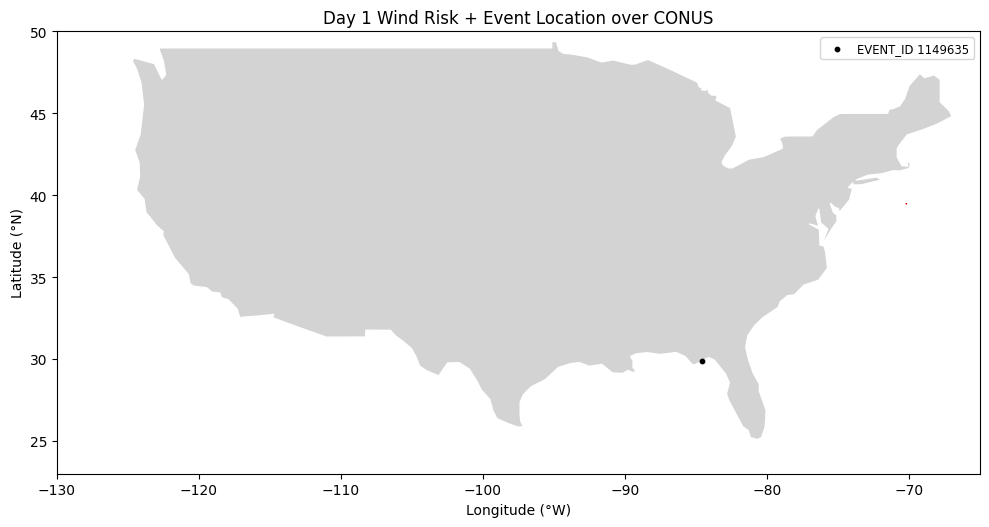

In [268]:
fig, ax = plt.subplots(figsize=(10, 6))
usa.plot(ax=ax, color="lightgray", edgecolor="white", label="USA")

wind.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=1,
    label="Day 1 Wind Risk"
)
gdf_pt.plot(
    ax=ax,
    marker="o",
    color="black",
    markersize=10,
    label="EVENT_ID 1149635"
)

ax.set_xlim(-130, -65)
ax.set_ylim(23, 50)
ax.set_xlabel("Longitude (°W)")
ax.set_ylabel("Latitude (°N)")
ax.set_title("Day 1 Wind Risk + Event Location over CONUS")
ax.legend(loc="upper right", fontsize="small")

plt.tight_layout()
plt.show()


In [269]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta

CONUS_BOUNDS = (-130, -65, 23, 50)    
COLORS = {"Tornado": "crimson",
          "Hail":    "royalblue",
          "Wind":    "seagreen"}        
CONV_DIR  = Path("/Users/jimnguyen/IRMII/SCS_API/convective_outlooks/2024/1/forecast_day1")
CONV_DIR_2 = Path("/Users/jimnguyen/IRMII/SCS_API/convective_outlooks/2024/1/forecast_day2")
STORM_CSV = Path("/Users/jimnguyen/IRMII/SCS_API/data/Storm_Reports/filtered/Storm_Reports_2024_latlon_filtered.csv")

In [270]:
storm = (storm_24
           .query("Month == 1")                 
           .assign(EVENT_TYPE=lambda d:
                   d.EVENT_TYPE.replace({"Strong Wind":"Wind",
                                          "Thunderstorm Wind":"Wind",
                                          "High Wind":"Wind"})))

gdf_events = gpd.GeoDataFrame(
    storm,
    geometry=gpd.points_from_xy(storm.LON, storm.LAT),
    crs="EPSG:4326"
)


In [271]:
storm

,DAY,EVENT_TYPE,LAT,LON,Month
0,8,Hail,30.0414,-96.3191,1
1,8,Hail,29.5000,-96.5700,1
2,8,Hail,33.1400,-91.0660,1
3,8,Hail,32.8500,-90.4100,1
4,8,Hail,31.0400,-89.1800,1
...,...,...,...,...,...
34410,10,Tornado,35.1960,-77.0561,1
34411,15,Tornado,27.1272,-80.3530,1
34412,27,Tornado,34.1614,-80.8590,1
34413,27,Tornado,34.1500,-81.7200,1


In [272]:
def get_day1_cat_shp(day):
    """
    Return the path to the last‑cycle Day1 categorical shapefile
    for the given YYYYMMDD string (e.g. '20240101').
    """
    dirs = sorted(CONV_DIR.glob(f"day1otlk_{day}_*/"), reverse=True)
    if not dirs:
        return None
    shp = next((d / f"{d.name}_cat.shp" for d in dirs
                if (d / f"{d.name}_cat.shp").exists()), None)
    return shp


In [285]:
def get_day2_cat_shp(day):
    dirs = sorted(CONV_DIR_2.glob(f"day2otlk_{day}_*/"), reverse=True)
    if not dirs:
        return None
    shp = next((d / f"{d.name}_cat.shp" for d in dirs
                if (d / f"{d.name}_cat.shp").exists()), None)
    return shp


In [286]:
def read_cat_standardised(shp_path):
    """
    Read an SPC categorical shapefile and return just geometry + a
    'RISK' column (MRGL / SLGT / ENH / MDT / HIGH).
    Works whether the file has LABEL2, LABEL, or neither.
    """
    gdf = gpd.read_file(shp_path)

    if "LABEL2" in gdf.columns:
        gdf["RISK"] = gdf["LABEL2"]              
    elif "LABEL" in gdf.columns:
        gdf["RISK"] = gdf["LABEL"].astype(str)   
    else:                                       
        dn_map = {1:"TSTM", 2:"MRGL", 3:"SLGT",
                  4:"ENH", 5:"MDT", 8:"HIGH"}
        gdf["RISK"] = gdf["DN"].map(dn_map).fillna("UNK")

    return gdf[["RISK", "geometry"]]


In [275]:
cat1_layers = []
cat2_layers = []

for dt in pd.date_range("2024-01-01", "2024-01-31", freq="D"):
    day = dt.strftime("%Y%m%d")

    shp1 = get_day1_cat_shp(day)
    if shp1:
        cat1_layers.append(
            read_cat_standardised(shp1).assign(DATE=dt)
        )

    shp2 = get_day2_cat_shp(day)
    if shp2:
        cat2_layers.append(
            read_cat_standardised(shp2).assign(DATE=dt)
        )

cat1 = gpd.GeoDataFrame(pd.concat(cat1_layers, ignore_index=True),
                         crs="EPSG:4326")
cat2 = gpd.GeoDataFrame(pd.concat(cat2_layers, ignore_index=True),
                         crs="EPSG:4326")


In [276]:
cat1_layers[0]['geometry']

0    POLYGON ((-110.86 31.15811, -110.86 31.97, -11...
Name: geometry, dtype: geometry

/var/folders/m8/6vszwx195fl9598f558j20ph0000gn/T/ipykernel_40798/100818950.py:4: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  cat_one = cat1.plot(ax=ax,
/var/folders/m8/6vszwx195fl9598f558j20ph0000gn/T/ipykernel_40798/100818950.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


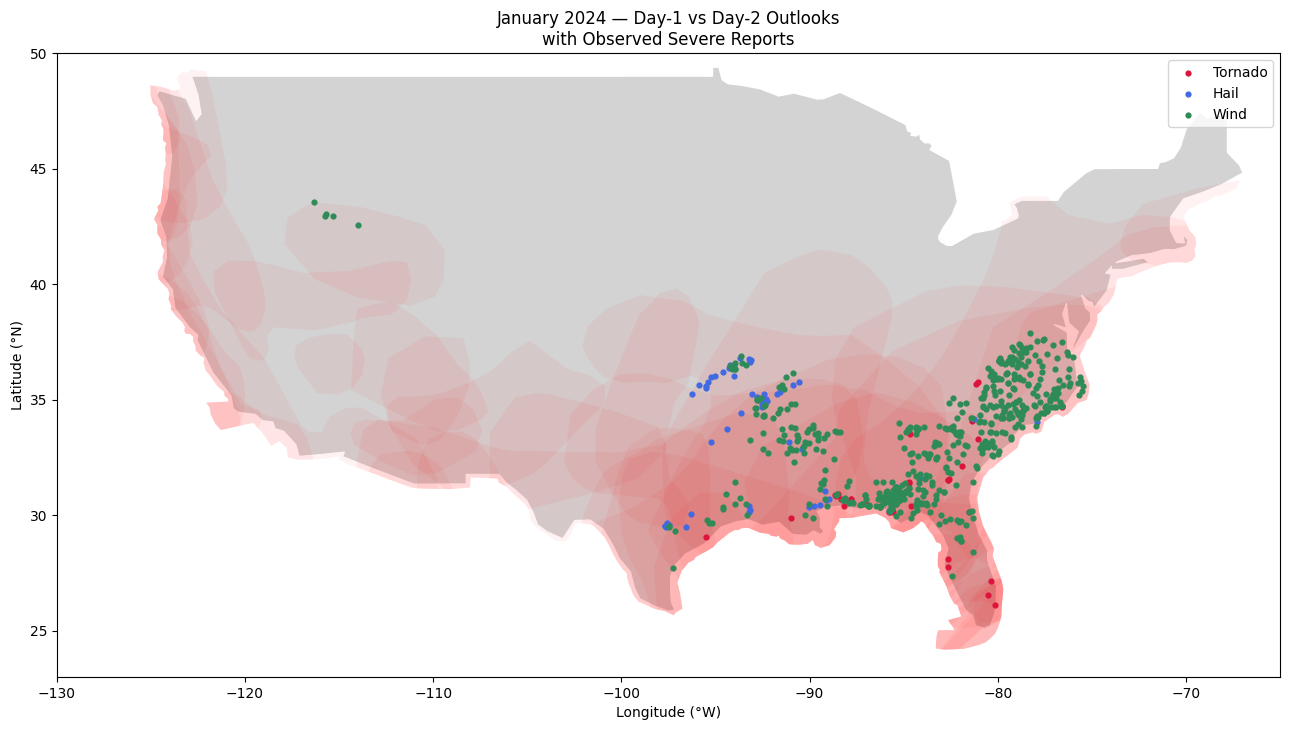

In [279]:
fig, ax = plt.subplots(figsize=(13, 8))
usa.plot(ax=ax, color="lightgray", edgecolor="white")

cat_one = cat1.plot(ax=ax,
          column="RISK",
          categorical=True,
          legend=True,
          alpha=0.05,
          color="red",
          label="Day 1 Outlook")

cat_two = cat2.plot(ax=ax,
          column="RISK",
          categorical=True,
          legend=True,
          alpha=0.05,
          color="yellow",
          label="Day 2 Outlook")

for etype, color in COLORS.items():
    subset = events_all[events_all.EVENT_TYPE == etype]
    subset.plot(ax=ax,
                
                markersize=12,
                color=color,
                marker="o",
                label=etype)

ax.set_xlim(*CONUS_BOUNDS[:2])
ax.set_ylim(*CONUS_BOUNDS[2:])
ax.set_xlabel("Longitude (°W)")
ax.set_ylabel("Latitude (°N)")
ax.set_title("January 2024 — Day-1 vs Day-2 Outlooks\nwith Observed Severe Reports")
ax.legend()
plt.tight_layout()
plt.show()


In [251]:
gpd.read_file(shp_path)

,DN,geometry
0,0,"POLYGON ((-70.19685 39.50669, -70.17781 39.468..."


In [189]:
print(gdf_evt.columns.tolist())


['DAY', 'EVENT_TYPE', 'LAT', 'LON', 'Month', 'geometry']


In [191]:
print(subset.geometry.is_empty.any(), subset.geometry.notnull().any())
print(subset.total_bounds)


False True
[nan nan nan nan]


# Checking 2019

In [307]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta

CONUS_BOUNDS = (-130, -65, 23, 50)    
COLORS = {"Tornado": "crimson",
          "Hail":    "royalblue",
          "Wind":    "seagreen"}        
CONV_DIR  = Path("/Users/jimnguyen/IRMII/SCS_API/convective_outlooks/2019/2/forecast_day1")
STORM_CSV = Path("/Users/jimnguyen/IRMII/SCS_API/data/Storm_Reports/filtered/Storm_Reports_2019_latlon_filtered.csv")

In [308]:
cat1_layers = []

for dt in pd.date_range("2019-02-01", "2019-02-28", freq="D"):
    day = dt.strftime("%Y%m%d")

    shp1 = get_day1_cat_shp(day)
    if shp1:
        cat1_layers.append(
            read_cat_standardised(shp1).assign(DATE=dt)
        )

cat1 = gpd.GeoDataFrame.set_crs(pd.concat(cat1_layers, ignore_index=True),
                         crs="EPSG:4326",allow_override=True)

In [330]:
cat1

,RISK,geometry,DATE
0,MRGL,"POLYGON ((-8068464.29054 9613684.8399, -804877...",2019-02-01
1,MRGL,"POLYGON ((-6842531.75565 6945189.12138, -68376...",2019-02-01
2,MRGL,"POLYGON ((-7167477.72875 6516851.24775, -71625...",2019-02-01
3,MRGL,"POLYGON ((-7556428.21171 10938085.85149, -7541...",2019-02-02
4,MRGL,"POLYGON ((-7310257.01997 8348364.91433, -73053...",2019-02-02
...,...,...,...
69,MRGL,"POLYGON ((-7654896.68841 8313900.94749, -76499...",2019-02-26
70,MRGL,"POLYGON ((-7413648.9205 8043112.63657, -740872...",2019-02-27
71,MRGL,"POLYGON ((-7073932.67589 7087968.4126, -706900...",2019-02-27
72,MRGL,"POLYGON ((-7098549.79506 10160184.88557, -7093...",2019-02-28


In [317]:
storm_19 = pd.read_csv('/Users/jimnguyen/IRMII/SCS_API/data/Storm_Reports/filtered/Storm_Reports_2019_latlong.csv')

In [318]:
storm_19 = storm_19.drop(['MONTH_NAME','END_DAY','STATE','CZ_TYPE','CZ_NAME','END_LAT','END_LON'],axis=1)
storm_19 = storm_19.drop(['YEAR'],axis=1)
storm_19 = storm_19.rename(columns={'BEGIN_LAT': 'LAT', 'BEGIN_LON': 'LON','MONTH_NUM':'Month','BEGIN_DAY':'DAY'})
storm_19

,DAY,EVENT_TYPE,LAT,LON,Month
0,4,Hail,37.3500,-84.3500,1
1,8,Hail,41.3700,-82.1200,1
2,8,Hail,41.5800,-81.4900,1
3,8,Hail,41.2400,-82.1200,1
4,8,Hail,41.3000,-81.8600,1
...,...,...,...,...,...
34718,29,Tornado,33.0978,-89.5429,12
34719,29,Tornado,33.1628,-89.4323,12
34720,29,Tornado,33.2598,-89.2778,12
34721,29,Tornado,33.4720,-89.0315,12


In [328]:
storm = (storm_19           
           .assign(EVENT_TYPE=lambda d:
                   d.EVENT_TYPE.replace({"Strong Wind":"Wind",
                                          "Thunderstorm Wind":"Wind",
                                          "High Wind":"Wind"})))

gdf_events = gpd.GeoDataFrame(
    storm,
    geometry=gpd.points_from_xy(storm.LON, storm.LAT),
    crs="EPSG:4326"
)
gdf_events

,DAY,EVENT_TYPE,LAT,LON,Month,geometry
0,4,Hail,37.3500,-84.3500,1,POINT (-84.35 37.35)
1,8,Hail,41.3700,-82.1200,1,POINT (-82.12 41.37)
2,8,Hail,41.5800,-81.4900,1,POINT (-81.49 41.58)
3,8,Hail,41.2400,-82.1200,1,POINT (-82.12 41.24)
4,8,Hail,41.3000,-81.8600,1,POINT (-81.86 41.3)
...,...,...,...,...,...,...
34718,29,Tornado,33.0978,-89.5429,12,POINT (-89.5429 33.0978)
34719,29,Tornado,33.1628,-89.4323,12,POINT (-89.4323 33.1628)
34720,29,Tornado,33.2598,-89.2778,12,POINT (-89.2778 33.2598)
34721,29,Tornado,33.4720,-89.0315,12,POINT (-89.0315 33.472)


/var/folders/m8/6vszwx195fl9598f558j20ph0000gn/T/ipykernel_40798/4069075308.py:4: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  cat_one = cat1.plot(ax=ax,
/var/folders/m8/6vszwx195fl9598f558j20ph0000gn/T/ipykernel_40798/4069075308.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/m8/6vszwx195fl9598f558j20ph0000gn/T/ipykernel_40798/4069075308.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


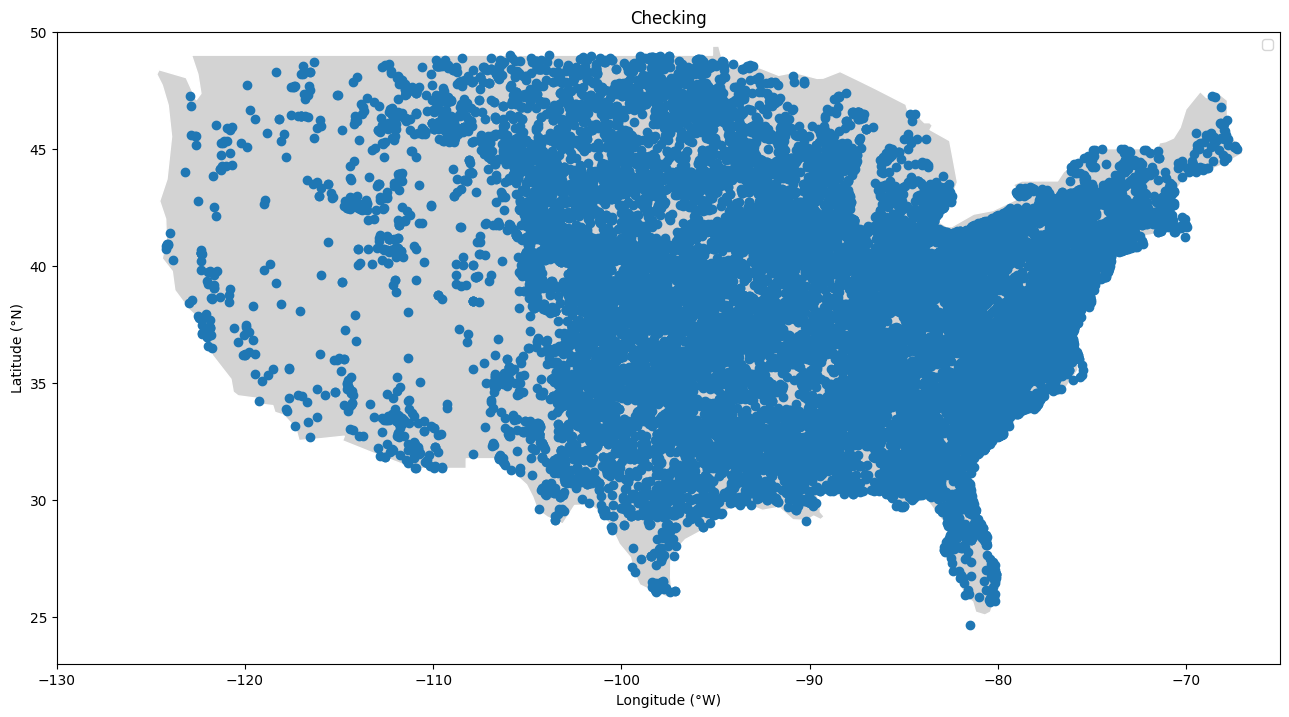

In [327]:
fig, ax = plt.subplots(figsize=(13, 8))
usa.plot(ax=ax, color="lightgray", edgecolor="white")

cat_one = cat1.plot(ax=ax,
          column="RISK",
          categorical=True,
          legend=True,
          alpha=0.05,
          color="red",
          label="Day 1 Outlook")

gdf = gdf_events.plot(ax=ax)

ax.set_xlim(*CONUS_BOUNDS[:2])
ax.set_ylim(*CONUS_BOUNDS[2:])
ax.set_xlabel("Longitude (°W)")
ax.set_ylabel("Latitude (°N)")
ax.set_title("Checking")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import os
import pandas as pd
import xarray as xr

"Code is complete, but the grid spacing is wrong"
"We need to get nam211, which is 80km grid spacing, but all I could find is "
"nam212, which is 40km grid spacing"

sigma_grid_units = 1.5
grid_spacing_km = 40.0   

# Download and Load NAM-212 grid 
url = 'https://github.com/ahaberlie/PPer_Climo/tree/master/data'
try:
    grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/nam212.nc") #Set to your folder pathway
    grid212_lat = grid_ds["gridlat_212"].values  # (ny, nx)
    grid212_lon = grid_ds["gridlon_212"].values  # (ny, nx)
    print(f"Loaded grid with shape: {grid212_lat.shape}")
except Exception as e:
    print(f"Error loading grid file: {e}")
    exit(1)

storm_dirs = {
    "torn": "tornado_reports",
    "wind": "wind_reports",
    "hail": "hail_reports"
}

# Distance function for PPH
def euclidean_distance_km(grid_lat, grid_lon, report_lat, report_lon):
    lat_km = 111.32 * (grid_lat - report_lat)
    lon_km = 111.32 * np.cos(np.radians(report_lat)) * (grid_lon - report_lon)
    return np.sqrt(lat_km**2 + lon_km**2)

# Create output directory
output_folder = "nam212_pph"
os.makedirs(output_folder, exist_ok=True)

# Go through each storm type
for storm_type, folder in storm_dirs.items():
    print(f"\nProcessing {storm_type} reports...")
    
    # Create output subfolder for this storm type
    output_subfolder = os.path.join(output_folder, storm_type)
    os.makedirs(output_subfolder, exist_ok=True)
    
    for year in range(2010, 2025): #Set to (first year, lastyear + 1)
        for month in range(1, 13):
            file_name = f"{storm_type}_{month}_{year}.csv"
            file_path = os.path.join(folder, file_name)
            
            if not os.path.exists(file_path):
                print(f"    File does not exist: {file_path}")
                continue

            try:
                # Read and clean data
                data = pd.read_csv(file_path)
                data['Lat'] = pd.to_numeric(data['Lat'], errors='coerce')
                data['Lon'] = pd.to_numeric(data['Lon'], errors='coerce')
                data['Day'] = pd.to_numeric(data['Day'], errors='coerce')
                
                # Remove rows with missing  data
                initial_count = len(data)
                data = data.dropna(subset=['Lat', 'Lon', 'Day'])
                if len(data) < initial_count:
                    print(f"    Removed {initial_count - len(data)} rows with missing data")

                # Filter to CONUS bounds
                conus_data = data[(data['Lat'] >= 24.52) & (data['Lat'] <= 49.385) &
                                 (data['Lon'] >= -124.74) & (data['Lon'] <= -66.95)]

                if len(conus_data) < len(data):
                    print(f"    Filtered {len(data) - len(conus_data)} reports outside CONUS")
                
                data = conus_data

                if len(data) == 0:
                    print(f"    No valid data for {year}-{month:02d}")
                    continue

                # Process each day
                for day in sorted(data['Day'].unique()):
                    day_data = data[data['Day'] == day]
                    
                    if len(day_data) == 0:
                        continue
                    
                    # Initialize the sum for PPH
                    gaussian_sum = np.zeros_like(grid212_lat, dtype=np.float64)

                    # Compute the PPH 
                    for _, row in day_data.iterrows():
                        d_km = euclidean_distance_km(
                            grid212_lat, grid212_lon,
                            row['Lat'], row['Lon']
                        )
                        
                        # Convert to grid units 
                        d_grid = d_km / grid_spacing_km
                        
                        # Summing the Nth terms 
                        gaussian_sum += np.exp(-0.5 * (d_grid / sigma_grid_units) ** 2)

                    # Apply prefactor: (1 / (2π sigma²)) 
                    gauss_pref = 1.0 / (2.0 * np.pi * sigma_grid_units**2)
                    daily_pph = gauss_pref * gaussian_sum
                    rounded_pph = np.round(daily_pph, 10)

                    # Saving
                    file_name_out = f"pph_{year}_{month:02d}_{int(day):02d}.csv"
                    output_file = os.path.join(output_subfolder, file_name_out)

                    try:
                        df = pd.DataFrame(rounded_pph)
                        df.to_csv(output_file, index=False)
                        
                        print(f"Calculated PPH for {storm_type} on {year}-{month:02d}-{int(day):02d} ")
                        
                    except Exception as e:
                        print(f"    Error saving PPH for {year}-{month:02d}-{int(day):02d}: {e}")
                        continue

            except Exception as e:
                print(f"    Error processing file {file_path}: {e}")
                continue

print("PPH Download complete")